<a href="https://colab.research.google.com/github/daspartho/fastai-part2/blob/main/meanshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Create data

In [157]:
n_clusters = 5
n_samples = 200

In [158]:
import torch

In [159]:
torch.manual_seed(32)
centroids = (torch.rand(n_clusters, 2)*50)-25 # between -25 and 25
centroids

tensor([[ 18.7827, -11.3967],
        [ -4.2972,  14.2862],
        [-19.3516,   3.9671],
        [  7.4038, -23.8544],
        [  4.3709,  -8.7309]])

In [160]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [161]:
covariance_matrix = torch.diag(tensor([5.,5.]))
def sample(m):
    return MultivariateNormal(m, covariance_matrix).sample((n_samples,))

In [162]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data, data.shape

(tensor([[ 17.6842, -11.7857],
         [ 14.1956,  -8.1366],
         [ 16.4673, -11.2534],
         ...,
         [  2.3255,  -2.1600],
         [  4.2049,  -7.5428],
         [  4.0484,  -8.4856]]), torch.Size([1000, 2]))

In [163]:
import matplotlib.pyplot as plt

In [164]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None:
        _,ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples: (i+1)*n_samples]
        ax.scatter(samples[:,0], samples[:,1],s=1)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)

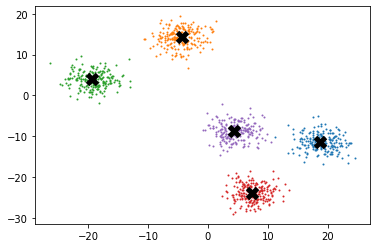

In [165]:
plot_data(centroids, data, n_samples)